In [1216]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u, constants as c
u.ndim = u.dimensionless_unscaled
import skrf as rf
rf.stylely()
from scipy.optimize import minimize

In [1218]:
#One L-section

In [1228]:
R_L = 1000*u.ohm
X_L = 0*u.ohm
R_S = (100 + 0*1j)*u.ohm
f = 75*u.MHz
#frequency = np.arange(1, 151, 1)*u.MHz
frequency = (np.linspace(1, 150, 150))*u.MHz
omega = 2*np.pi*frequency # MHz
f_0_str = '75MHz'

In [1230]:
B1 = (X_L + np.sqrt(R_L/R_S)*np.sqrt(R_L**2 + X_L**2 - R_S*R_L))/(R_L**2 + X_L**2)
B2 = (X_L - np.sqrt(R_L/R_S)*np.sqrt(R_L**2 + X_L**2 - R_S*R_L))/(R_L**2 + X_L**2)
X1 = (1/B1) + (X_L*R_S)/R_L - R_S/(B1*R_L)
X2 = (1/B2) + (X_L*R_S)/R_L - R_S/(B2*R_L)

In [1232]:
if B1 > 0:
    print(f"B1 is a capacitor, B1 = {B1:.6f}")
    cap1 = B1/(2*np.pi*f)
    C1 = cap1.to(u.F)
else: 
    print(f"B1 is an inductor, B1 = {B1:.6f}")
    ind1 = -1/(2*np.pi*f*B1)
    L1 = ind1.to(u.H)
if X1 > 0:
    print(f"X1 is an inductor, X1 = {X1:.6f}")
    ind1 = X1/(2*np.pi*f)
    L1 = ind1.to(u.H)
else:
    print(f"X1 is a capacitor, X1 = {X1:.6f}")
    cap1 = -1/(2*np.pi*f*X1)
    C1 = cap1.to(u.F)
    
if B2 > 0:
    print(f"B2 is a capacitor, B2 = {B2:.6f}")
    cap2 = B2/(2*np.pi*f)
    C2 = cap2.to(u.F)
else: 
    print(f"B2 is an inductor, B2 = {B2:.6f}")
    ind2 = -1/(2*np.pi*f*B2)
    L2 = ind2.to(u.H)
if X2 > 0:
    print(f"X2 is an inductor, X2 = {X2:.6f}")
    ind2 = X2/(2*np.pi*f)
    L2 = ind2.to(u.H)
else:
    print(f"X2 is a capacitor, X2 = {X2:.6f}")
    cap2 = -1/(2*np.pi*f*X2)
    C2 = cap2.to(u.F)

B1 is a capacitor, B1 = 0.003000+0.000000j 1 / Ohm
X1 is an inductor, X1 = 300.000000+0.000000j Ohm
B2 is an inductor, B2 = -0.003000+0.000000j 1 / Ohm
X2 is a capacitor, X2 = -300.000000+0.000000j Ohm


(<Quantity 6.36619772e-12+0.j F>,
 <Quantity 6.36619772e-07+0.j H>,
 <Quantity 7.07355303e-07+0.j H>,
 <Quantity 7.07355303e-12+0.j F>)

In [1234]:
circuit1_Z = 1j*omega*L1 + (1j*omega*C1 + 1/R_L)**(-1)
circuit2_Z = 1/(1j*omega*C2) + (1/(1j*omega*L2) + 1/R_L)**(-1)

Reflection1 = np.abs(((circuit1_Z - Z_0)/(circuit1_Z + Z_0)).to(u.ndim))
Reflection2 = np.abs(((circuit2_Z - Z_0)/(circuit2_Z + Z_0)))

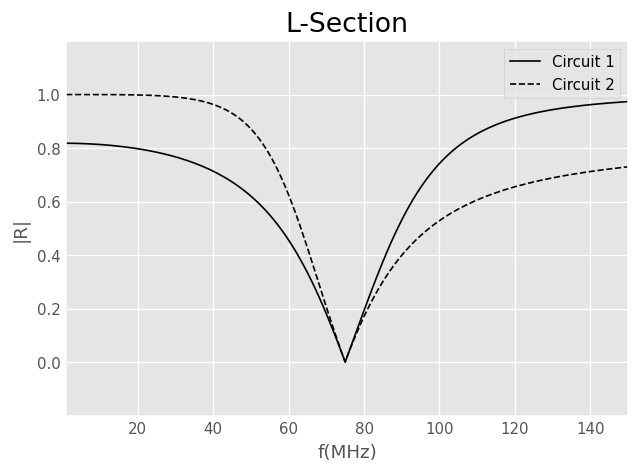

In [1236]:
plt.plot(frequency, Reflection1, color='k', linestyle='-', label='Circuit 1')
plt.plot(frequency, Reflection2, color='k', linestyle='--', label='Circuit 2')
plt.ylabel("|R|")
plt.xlabel("f(MHz)")
plt.title("L-Section")
plt.legend(loc="upper right")
plt.show()

In [1238]:
Q_s1 = X1/R_S
Q_p1 = R_L/(1/B1)
Q_s2 = X2/R_S
Q_p2 = R_L/(1/B2)
Q_s1, Q_p1, Q_s2, Q_p2

(<Quantity 3.+0.j>, <Quantity 3.+0.j>, <Quantity -3.+0.j>, <Quantity -3.-0.j>)

In [1240]:
#Max bandwidth
R_min = np.sqrt(R_S*R_L)
Q_min = np.sqrt(R_min/R_S - 1)
Q_min

<Quantity 1.47046852+0.j>

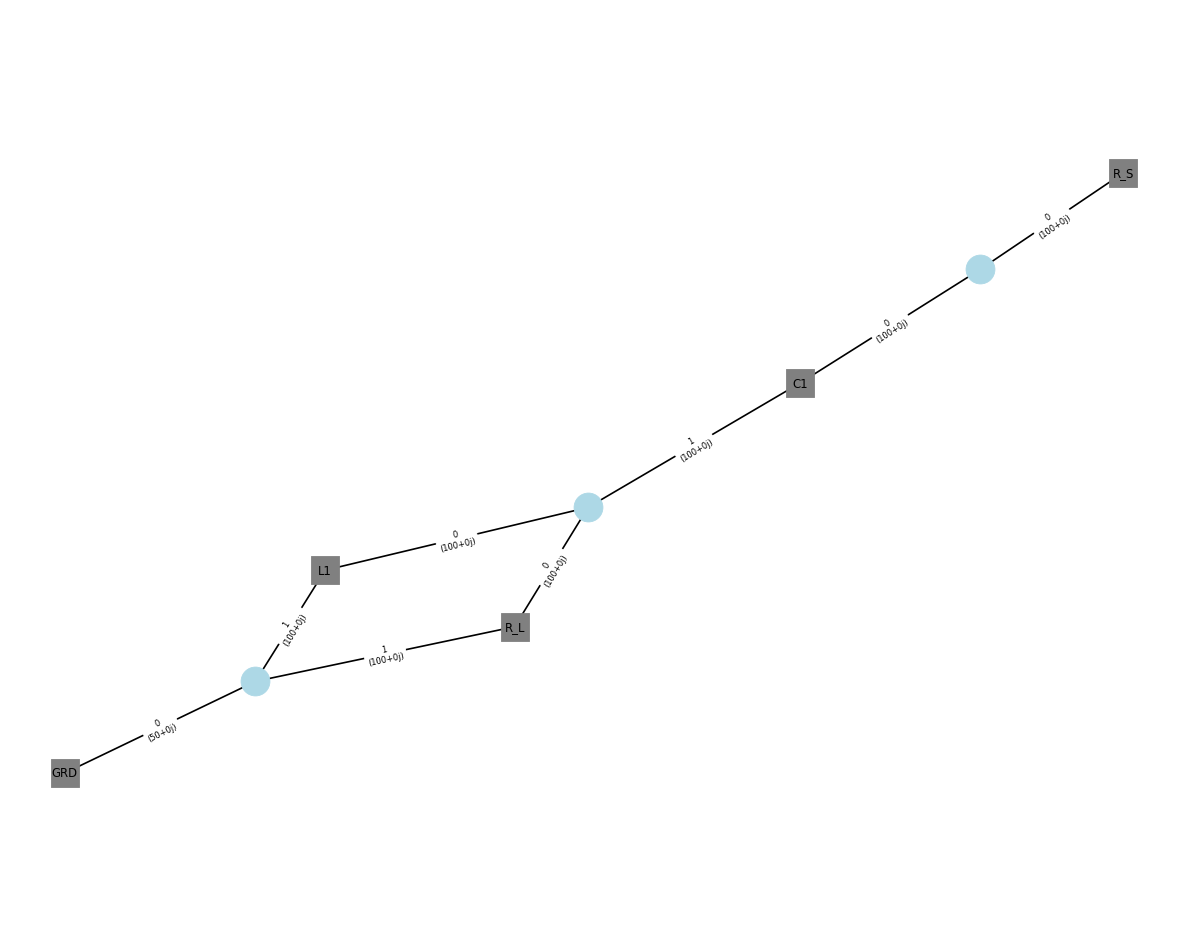

In [1242]:
freq = rf.Frequency(start=25, stop=125, npoints=126, unit='MHz')
line = rf.media.DefinedGammaZ0(frequency=freq, z0=R_S)
series_C1 = line.capacitor(C1, name='C1')
shunt_L1 = line.inductor(L1, name='L1')
port = rf.Circuit.Port(freq, name='R_S', z0=R_S)
load = line.resistor(R_L, name='R_L')
ground = rf.Circuit.Ground(freq, name='GRD')
connections = [
    [(port, 0), (series_C1, 0)],
    [(series_C1, 1), (shunt_L1, 0), (load, 0)],
    [(shunt_L1, 1), (load, 1), (ground, 0)],
]

circuit = rf.Circuit(connections)
LC_from_circuit = circuit.network
circuit.plot_graph(network_labels=True, edge_labels=True, port_labels=True)

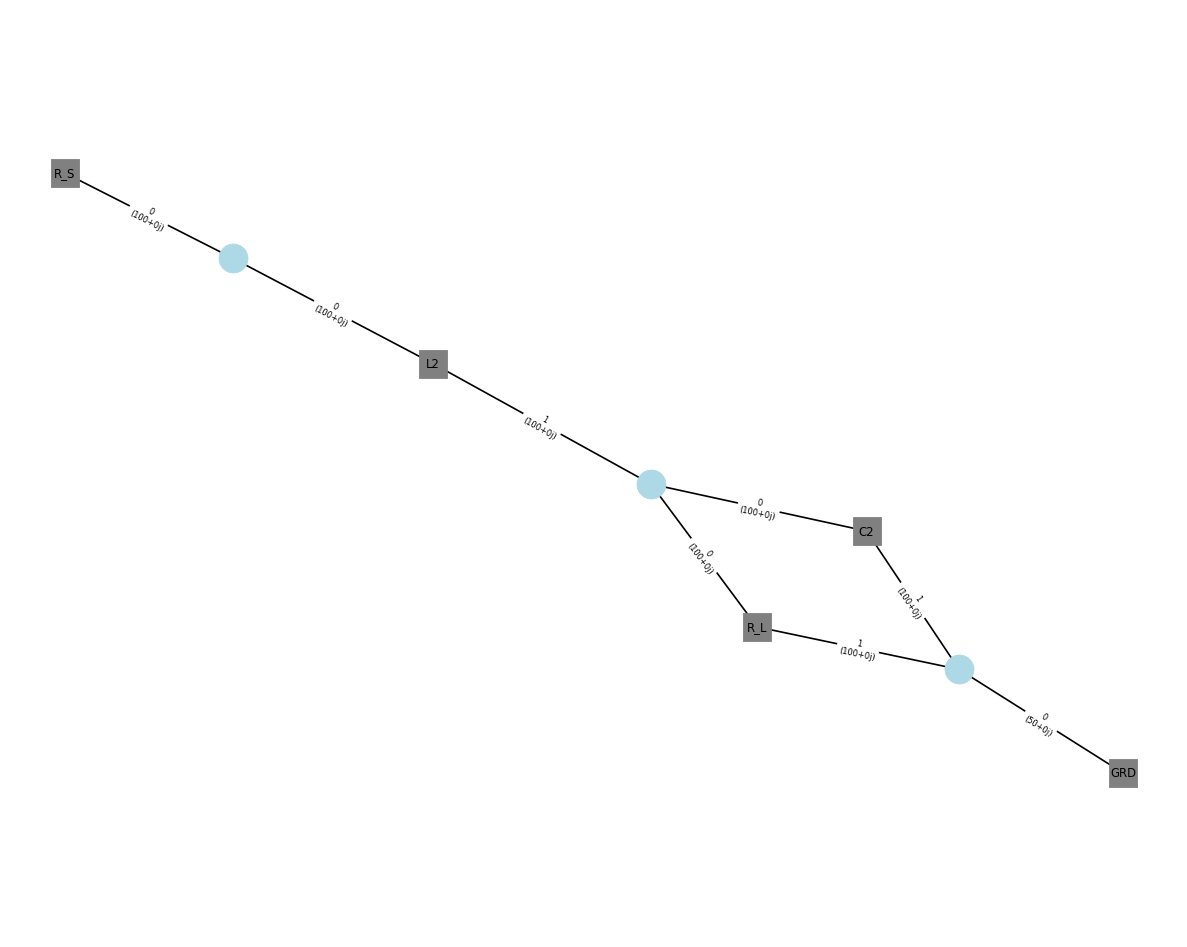

In [1248]:
freq = rf.Frequency(start=1, stop=151, npoints=151, unit='MHz')
line = rf.media.DefinedGammaZ0(frequency=freq, z0=R_S)
series_L2 = line.capacitor(L2, name='L2')
shunt_C2 = line.inductor(C2, name='C2')
port = rf.Circuit.Port(freq, name='R_S', z0=R_S)
load = line.resistor(R_L, name='R_L')
ground = rf.Circuit.Ground(freq, name='GRD')
connections = [
    [(port, 0), (series_L2, 0)],
    [(series_L2, 1), (shunt_C2, 0), (load, 0)],
    [(shunt_C2, 1), (load, 1), (ground, 0)],
]

circuit = rf.Circuit(connections)
LC_from_circuit = circuit.network
circuit.plot_graph(network_labels=True, edge_labels=True, port_labels=True)

(-0.2, 1.2)

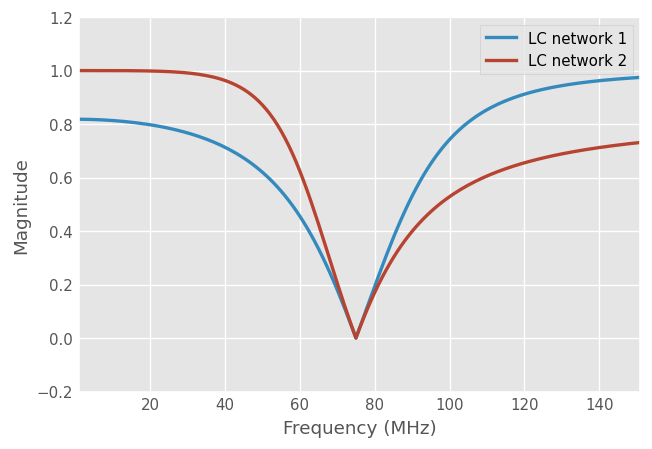

In [1256]:
load_net = line.load(rf.zl_2_Gamma0(R_S, R_L))
def matching_network_LC_1(L, C):
    ' L and C in nH and pF'
    return line.inductor(L*1e-9)**line.shunt_capacitor(C*1e-12)**load_net

def matching_network_LC_2(L, C):
    ' L and C in nH and pF'
    return line.capacitor(C*1e-12)**line.shunt_inductor(L*1e-9)**load_net

# initial guess values
L0 = 600
C0 = 6
x0 = (L0, C0)
# bounds
L_minmax = (1, 1000) 
C_minmax = (0.1, 10)

# the objective functions minimize the return loss at the target frequency f_0
def optim_fun_1(x, f0=f_0_str):
    _ntw = matching_network_LC_1(*x)
    return np.abs(_ntw[f_0_str].s).ravel()

def optim_fun_2(x, f0=f_0_str):
    _ntw = matching_network_LC_2(*x)
    return np.abs(_ntw[f_0_str].s).ravel()

res1 = minimize(optim_fun_1, x0, bounds=(L_minmax, C_minmax))
res2 = minimize(optim_fun_2, x0, bounds=(L_minmax, C_minmax))
ntw1 = matching_network_LC_1(*res1.x)
ntw2 = matching_network_LC_2(*res2.x)

# Note that the match is perfect at the resonant frequency
ntw1.plot_s_mag(lw=2, label='LC network 1')
ntw2.plot_s_mag(lw=2, label='LC network 2')
plt.ylim([-0.2,1.2])

In [1152]:
# Three element matching -- Pi circuit -- higher Q -- smaller bandwidth

![Screenshot 2025-07-07 at 11.50.29 AM.png](attachment:5a0a64b6-dc26-4aa5-9c2b-15fd68fb5094.png)

In [1155]:
Q = 3.1
R_H = R_L # higher impedance of R_S and R_L
R = R_H/(Q**2 + 1)
R

<Quantity 94.25070688 Ohm>

In [1157]:
R_p2 = R_L # shunt resistance
R_s2 = R # series resistance (virtual in this instance)
X_p2 = R_p2/Q
X_s2 = Q*R_s2
X_p2, X_s2

(<Quantity 322.58064516 Ohm>, <Quantity 292.17719133 Ohm>)

In [1159]:
Q1 = np.sqrt(R_S/R - 1) # need new Q for left side (ratio of source resistance to virtual)
Q1

<Quantity 0.24698178+0.j>

In [1161]:
R_p1 = R_S # shunt resistance
R_s1 = R # series resistance (virtual in this instance)
X_p1 = R_p1/Q1
X_s1 = Q1*R_s1
X_p1, X_s1

(<Quantity 404.88816509+0.j Ohm>, <Quantity 23.27820742+0.j Ohm>)

In [1163]:
def parallel(x, y):
    return (1/x + 1/y)**(-1)
def capacitor(x):
    return (1/(1j*2*np.pi*frequency*x)).to(u.ohm)
def inductor(x):
    return (1j*2*np.pi*frequency*x).to(u.ohm)

In [1165]:
cap_p1 = (1/(2*np.pi*f*X_p1)).to(u.F)
C_p1 = capacitor(cap_p1) # ohms
ind_p1 = (X_p1/(2*np.pi*f)).to(u.H)
L_p1 = inductor(ind_p1) # ohms

cap_s1 = (1/(2*np.pi*f*X_s1)).to(u.F)
C_s1 = capacitor(cap_s1) # ohms
ind_s1 = (X_s1/(2*np.pi*f)).to(u.H)
L_s1 = inductor(ind_s1) # ohms

cap_p2 = (1/(2*np.pi*f*X_p2)).to(u.F)
C_p2 = capacitor(cap_p2) # ohms
ind_p2 = (X_p2/(2*np.pi*f)).to(u.H)
L_p2 = inductor(ind_p2) # ohms

cap_s2 = (1/(2*np.pi*f*X_s2)).to(u.F)
C_s2 = capacitor(cap_s2) # ohms
ind_s2 = (X_s2/(2*np.pi*f)).to(u.H)
L_s2 = inductor(ind_s2) # ohms


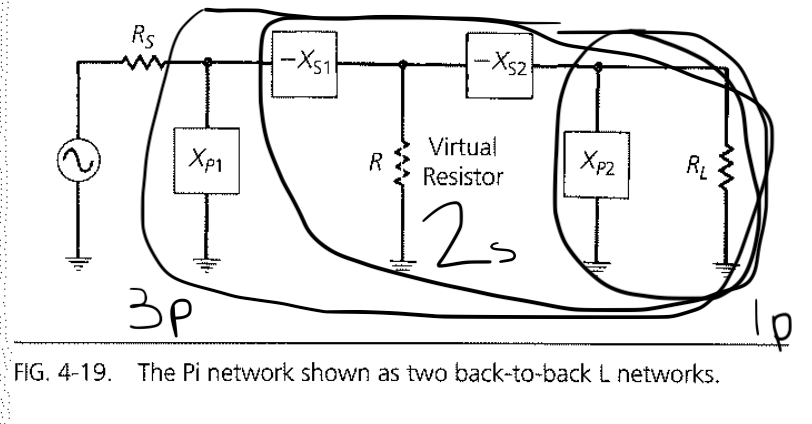

In [1168]:
#option 1: C_p1, L_s1, C_p2, L_s2
loop1_1 = parallel(C_p2, R_L)
loop2_1 = loop1_1 + L_s1 + L_s2
loop3_1 = parallel(C_p1, loop2_1)
reflection_opt1 = np.abs(((loop3_1 - R_S)/(loop3_1 + R_S)).to(u.ndim))
idx = np.argmin(np.abs(frequency - 75*u.MHz))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt1[idx]:.4f}")

Reflection at 75.00 MHz: 0.0000


In [1170]:
#option 2: C_p1, L_s1, L_p2, C_s2
loop1_2 = parallel(L_p2, R_L)
loop2_2 = loop1_2 + L_s1 + C_s2
loop3_2 = parallel(C_p1, loop2_2)
reflection_opt2 = np.abs(((loop3_2 - R_S)/(loop3_2 + R_S)).to(u.ndim))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt2[idx]:.4f}")

Reflection at 75.00 MHz: 0.0000


In [1172]:
#option 3: L_p1, C_s1, L_p2, C_s2
loop1_3 = parallel(L_p2, R_L)
loop2_3 = loop1_3 + C_s1 + C_s2
loop3_3 = parallel(L_p1, loop2_3)
reflection_opt3 = np.abs(((loop3_3 - R_S)/(loop3_3 + R_S)).to(u.ndim))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt3[idx]:.4f}")

Reflection at 75.00 MHz: 0.0000


In [1174]:
#option 4: L_p1, C_s1, C_p2, L_s2
loop1_4 = parallel(C_p2, R_L)
loop2_4 = loop1_4 + C_s1 + L_s2
loop3_4 = parallel(L_p1, loop2_4)
reflection_opt4 = np.abs(((loop3_4 - R_S)/(loop3_4 + R_S)).to(u.ndim))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt4[idx]:.4f}")

Reflection at 75.00 MHz: 0.0000


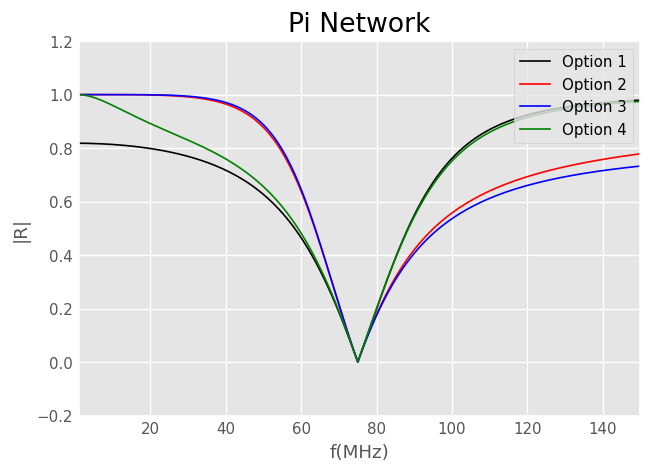

In [1176]:
plt.plot(frequency, reflection_opt1, color='k', label='Option 1')
plt.plot(frequency, reflection_opt2, color='r', label='Option 2')
plt.plot(frequency, reflection_opt3, color='b', label='Option 3')
plt.plot(frequency, reflection_opt4, color='g', label='Option 4')
plt.ylabel("|R|")
plt.xlabel("f(MHz)")
plt.title("Pi Network")
plt.legend(loc="upper right")
plt.show()

In [1178]:
# Three element matching -- lower Q -- series leg (R_L > R_S)-- wider bandwidth

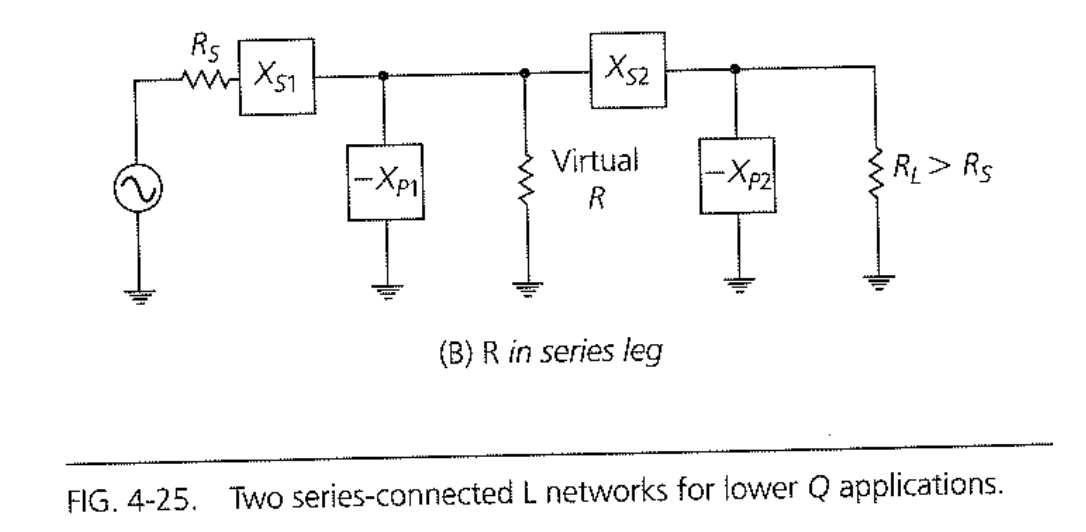

In [1181]:
Q = 1.5
R = R_L/(Q**2 + 1)
R

<Quantity 307.69230769 Ohm>

In [1183]:
R_p1 = R
R_s1 = R_S
X_p1 = R_p1/Q
X_s1 = Q*R_s1
X_p1, X_s1

(<Quantity 205.12820513 Ohm>, <Quantity 150.+0.j Ohm>)

In [1185]:
R_p2 = R_L # shunt resistance
R_s2 = R # series resistance (virtual in this instance)
X_p2 = R_p2/Q
X_s2 = Q*R_s2
X_p2, X_s2

(<Quantity 666.66666667 Ohm>, <Quantity 461.53846154 Ohm>)

In [1187]:
cap_p1 = (1/(2*np.pi*f*X_p1)).to(u.F)
C_p1 = capacitor(cap_p1) # ohms
ind_p1 = (X_p1/(2*np.pi*f)).to(u.H)
L_p1 = inductor(ind_p1) # ohms

cap_s1 = (1/(2*np.pi*f*X_s1)).to(u.F)
C_s1 = capacitor(cap_s1) # ohms
ind_s1 = (X_s1/(2*np.pi*f)).to(u.H)
L_s1 = inductor(ind_s1) # ohms

cap_p2 = (1/(2*np.pi*f*X_p2)).to(u.F)
C_p2 = capacitor(cap_p2) # ohms
ind_p2 = (X_p2/(2*np.pi*f)).to(u.H)
L_p2 = inductor(ind_p2) # ohms

cap_s2 = (1/(2*np.pi*f*X_s2)).to(u.F)
C_s2 = capacitor(cap_s2) # ohms
ind_s2 = (X_s2/(2*np.pi*f)).to(u.H)
L_s2 = inductor(ind_s2) # ohms

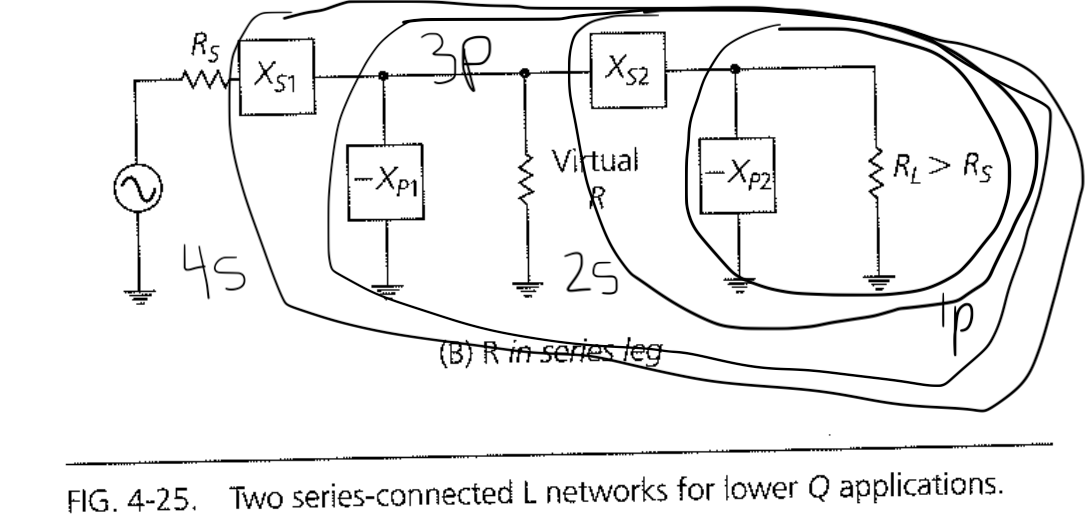

In [1190]:
#option 1: C_p1, L_s1, C_p2, L_s2
loop1_1 = parallel(C_p2, R_L)
loop2_1 = loop1_1 + L_s2
loop3_1 = parallel(C_p1, loop2_1)
loop4_1 = loop3_1 + L_s1
reflection_opt1 = np.abs(((loop4_1 - R_S)/(loop4_1 + R_S)).to(u.ndim))
idx = np.argmin(np.abs(frequency - 75*u.MHz))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt1[idx]:.4f}")

Reflection at 75.00 MHz: 0.0493


In [1192]:
#option 2: C_p1, L_s1, L_p2, C_s2
loop1_2 = parallel(L_p2, R_L)
loop2_2 = loop1_2 + C_s2
loop3_2 = parallel(C_p1, loop2_2)
loop4_2 = loop3_2 + L_s1
reflection_opt2 = np.abs(((loop4_2 - R_S)/(loop4_2 + R_S)).to(u.ndim))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt2[idx]:.4f}")

Reflection at 75.00 MHz: 0.0493


In [1194]:
#option 3: L_p1, C_s1, L_p2, C_s2
loop1_3 = parallel(L_p2, R_L)
loop2_3 = loop1_3 + C_s2
loop3_3 = parallel(L_p1, loop2_3)
loop4_3 = loop3_3 + C_s1
reflection_opt3 = np.abs(((loop4_3 - R_S)/(loop4_3 + R_S)).to(u.ndim))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt3[idx]:.4f}")

Reflection at 75.00 MHz: 0.0493


In [1196]:
#option 4: L_p1, C_s1, C_p2, L_s2
loop1_4 = parallel(C_p2, R_L)
loop2_4 = loop1_4 + L_s2
loop3_4 = parallel(L_p1, loop2_4)
loop4_4 = loop3_4 + C_s1
reflection_opt4 = np.abs(((loop4_4 - R_S)/(loop4_4 + R_S)).to(u.ndim))
print(f"Reflection at {frequency[idx]:.2f}: {reflection_opt4[idx]:.4f}")

Reflection at 75.00 MHz: 0.0493


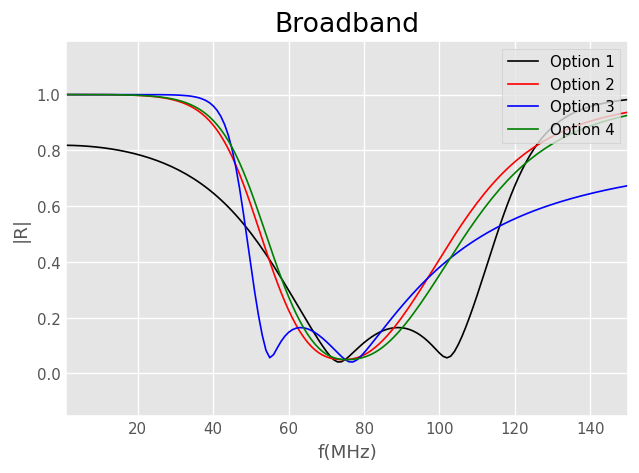

In [1198]:
plt.plot(frequency, reflection_opt1, color='k', label='Option 1')
plt.plot(frequency, reflection_opt2, color='r', label='Option 2')
plt.plot(frequency, reflection_opt3, color='b', label='Option 3')
plt.plot(frequency, reflection_opt4, color='g', label='Option 4')
plt.ylabel("|R|")
plt.xlabel("f(MHz)")
plt.title("Broadband")
plt.legend(loc="upper right")
plt.show()